# Connectivity Tests for Safety of CAVs

## Decentralized Intelligence

### Scenario

A vehicle is moving forward while being connected to $N-1$ peers. Each peer $i$ is sending a timestamped message $m^{(n)}_t$ containing important information about the shared space, i.e. environment state. At some point $t_e$ an event occur that will eventually lead to an unwanted outcome, e.g. collision. To avoid collision we use the incoming messages to detect the causal event. Consequently, the vehicle must process all messages in the *safety-critical function* $F(m^{(1)}_t, m^{(2)}_t, ...)$. When $F$ has detected the event it starts braking the vehicle. We assume the ego vehicle travels at a constant velocity $v$ straight towards the eventual collision from the start of the scenario. In fact, with the vehicle starting at $x=x_0$ and the *collision point* at $x=0$, we can set the vehicle dynamics to simply be $\dot{x} = v$. With $t$ growing backwards in time we start the scenario at $t=t_0$ and end it with the eventual collision (assuming the vehicle never brakes) at $t=0$, i.e. $v = \frac{x_0}{t_0}$.

```
    Start       Event           Collision
    .           .               |
    .           .               |    
[Ego]=>         .               |
    .           .               |
    .           .               |
t:  t0          te              0

(P-1)
(P-2)
```

### Safety

The main goal of the vehicle is to remain safe and brake in time. However, safety depends of course on many things like the connectivity, the ability to react and the event itself. Since these tests focus on connectivity we will simplify $F$ accordingly. Firstly, as previously stated, $F$ requires the incoming messages. We will also use some fundamental assumptions about the ability to react, e.g. the only way to avoid collision is to brake, and we will not consider some more nuanced perspectives like how braking changes the velocity that in turn affect the internals of $F$ (what it means to be safe). That means $F$ is fundamentally a construction for requiring connectivity. However, we must still define what it means to be safe. When should $F$ be computed? Can, and if so, should $F$ be computed multiple times?

For simplicity we first assume that the ego vehicle is scheduled to compute $F$ on a clock with fixed interval $T_c$. We then define safety (over the entire test) as the following:

    SAFETY CRITERION
    ----------------
    The safety-critical function F is computed 
        (R1) on all
        (R2) on at least one 
    scheduled executions after the causal event.
    
We can choose to look through one of two perspectives by choosing either requirement `R1` or `R2`. Neither is more correct than the other since this detail inherently depends on the implementation of $F$. For convenience we call the two variations *strong-safety* and *weak-safety* respectively. However, remember that the safety in this case is only up until the connectivity requirements set up for these tests. In a broader scope these conditions **do not** satisfy safety since that would entail requirements on all layers of the system in question.

### Compute Time

The computation time of $F$ is for simplicity assumed to be the same as the scheduling interval, i.e. $T_c$. In reality, however, the computation time might depend on multiple variables. One such dependency could be the number of peers in the scenario. To incorporate this behavior we assume that the compute time (somehow) scales with the number of peers.

$$T_c = T \cdot N^{K}$$

With this we can describe $T_c$ in terms of $T$ and how the computation changes with more peers.

### Braking Distance

An important factor in deciding whether we will collide or not is the braking distance. This is a measure of the latest possible time we can react depending on the current velocity. The braking distance, in `[m]`, is roughly equal to 

$$ l_b = \frac{v^2}{250\mu} $$

where $v$ is the velocity in `[km/h]` and $\mu$ is the friction number. The friction number is typically $\mu=0.8$ for dry asphalt and $\mu=0.1$ for smooth ice. 

**Note**: Just use high-school formula and focus on velocity...

$$ v = v_0 + at \rightarrow \tau_b = \frac{v}{a} $$

In these experiments we could cautiously set $f=0.6$ and get the following approximate table:

| Velocity `[m/s]` | Braking distance `[m]` |
|------------------|------------------------|
| 5                | 2.1                    |
| 10               | 8.6                    |
| 20               | 34.5                   |

With the braking distance we can more specifically and formally define unsafe situations. For instance, consider the collision point $x=0$. After calculating the braking distance we can say that if the ego vehicle were to enter $x<l_b$ it will not stop in time and ultimately collide. We call $x<l_b$ the *collision zone* $\mathcal{CZ}$ and updates the safety criterion accordingly.

    SAFETY CRITERION
    ----------------
    The safety-critical function F is computed 
        (R1) on all
        (R2) on at least one 
    scheduled executions after the causal event,
    AND,
    the vehicle never enters the collision zone.

### Connectivity & Safety

The most central question in these tests is "How does connectivity relate to safety?". As stated previously, the safety criterion only depends on the computations of $F$ which in turn only depends on the incoming messages $m^{(n)}$. Consequently, we should investigate what affects the connectivity and how the messages will be delivered.

The communication medium is a wireless network. The network will add some latency which must be considered in any sort of safety criteria. Furthermore, this latency is affected by both the size $D$ and frequency $f$ of the messages. The communication architecture $A$ also affects the setup. For example, if the peers are in a direct P2P network then the latency will probably decrease compared to a centralized server based architecture.

For one execution of $F$, scheduled at time $t$, there will be a total *reaction time* $\tau_r$ from the latency $L(m_t^\prime)$ of a message and the computational time $T_c$. There will also be a slight delay $\delta$ due to scheduling differences between the receiving a message and the computation of $F$. For a direct P2P architecture the reaction time will be

$$
\tau^{(t)}_r = \max_n{L_a(m^{(n)}_{t^\prime_n})} + T_c,
$$

where $t$ is the time at which $F$ is scheduled and computed (we assume computation occurs at the exact scheduled time), $t^\prime_n$ is the time at which the latest received message $m^{(n)}$ was sent, and finally, $L_a(m) = L(m) + \delta = t - t^\prime$ is the apparent latency. The reaction time $\tau^{(t)}_r$ can be seen as a headway window moving along with the vehicle; if anything would occur inside this time window then the vehicle will not be able to react in response to the event (make a decision).

Furthermore, with the braking distance in mind and considering the reaction time, we can define the *dangerous zone* $\mathcal{DZ}$ of the vehicle. This zone constitutes the space in front of the vehicle with a length $l_d = v\tau_r + l_b$. If anything would occur inside this zone, even if the vehicle could detect it, it would not be able to stop in time. In other terms we want that $x-l_d>0$, or in headway time, $\tau > \tau_r + \frac{l_b}{v}$.

    SAFETY CRITERION
    ----------------
    The safety-critical function F is computed 
        (R1) on all
        (R2) on at least one 
    scheduled executions after the causal event,
    AND,
    the collision point is never in the dangerous zone.
    
Following is an illustration of both the dangerous zone and the collision zone.

```
    Start   DZ              CZ  Collision
    .       .               .   |
    .       .               .   |
[Ego]=>     .               .   |       
    .       .               .   |
    .       .               .   |
x:  x0      x0-ld           lb  0
```

## Test Cases and Automation

A test case executes a simulated run of the described scenario. The simulation is run in discrete time $k$ with timesteps $h=0.1$ seconds. The vehicle dynamics are defined by $x_{k+1} = x_k + vh$. Note that each vehicle simulates their own run and have their own discrete time, e.g. $k_{ego}$. This requires that the vehicles are time synchronized.

Each test case $\mathbf{T_i}$, indexed by $\mathbf{i}$, is defined by a configuration parameters $\mathbf{P_i}$ and produces logs for all vehicles. The configuration parameters could be structured as a 7-tuple $\mathbf{P} = (N, x_0, v, f, D, T, K)$ for the corresponding variables discussed earlier.

In [1]:
## Imports ##

import json
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.colors import BASE_COLORS

## Constants: Data ##

PROJ_DIR = Path().absolute().parent

FIELD_SEP = ','
ENTRY_SEP = ';'

CFG_FIELDS = {
    'test':             str,
    'init_pos':         float, # [m]    = x0
    'targ_vel':         float, # [m/s]  = v
    'time_step':        float, # [s]    = h
    'data_size':        float, # [kB]   = D
    'data_freq':        float, # [Hz]   = f
    'comp_time':        float, # [s]    = T
    'comp_ordr':        float, # [1]    = K

}

LOG_FIELDS = {
    'sender':           str,
    'sent':             int,   # [ns]   = t'
    'arrival':          int,   # [ns]   = t' + L(m)
    'valid':            bool, 
    'headway':          float, # [s]    = tau
    'last_sched':       int,   # [ns]
    'last_computed':    int,   # [ns]   = t
    'apparent_latency': int,   # [ns]   = t - t'
}

ALL_FIELDS = CFG_FIELDS | LOG_FIELDS

## Constants: Physics ## 

# https://content.tfl.gov.uk/bus-safety-standard-bus-braking-data-analysis.pdf
HARD_BRAKING = 3.0 # [m/s^2]
SOFT_BRAKING = 1.0 # [m/s^2]
ACCELERATION = SOFT_BRAKING

FRICTION = 0.6     # [1]

## Functions: Data collection ##

def load(test_suite: str):
    dfs = []
    
    test_paths = (PROJ_DIR / 'log' / test_suite).iterdir()
    
    for test_path in test_paths:
        
        cfg =  {'test': f'{test_suite}__{test_path.name}'}
        with open(test_path / 'conf') as file:
            cfg.update((key.lower(), val) 
                       for key, val in json.load(file).items())
            cfg['num_agents'] = len(cfg.pop('agents'))
        
        logs = filter(lambda p: p.name != 'conf', 
                      test_path.iterdir())
        
        for log in logs:
            with open(log) as file:
                table = pd.read_csv(file,
                                    names=LOG_FIELDS,
                                    dtype=LOG_FIELDS,
                                    lineterminator=ENTRY_SEP)
                table = table.assign(**cfg)
                dfs.append(table)

    return pd.concat(dfs, ignore_index=True).astype(ALL_FIELDS)

def get_color(i):
    cs = list(BASE_COLORS)
    return cs[int(i) % len(cs)]

def get_test(df, name, test_case=None):
    test = (
        name if test_case is None else
        f'{name}__{test_case}'
    )
    mask = df['test'] == test
    return df[mask]

def get_random_test(df):
    return df.groupby('test').sample(1)

def get_latest_from(df, by=None):
    return df.groupby(by, as_index=False).tail(1)

## Functions: Time windows ##

def compute_time(df):
    return (
        df['comp_time']
        * df['num_agents']**df['comp_ordr']
    ) # [s]

def braking_time(df):
    return df['targ_vel'].max() / ACCELERATION # [s]

def danger_time(df):
    df = get_latest_from(df, 'sender')
    tr = df['apparent_latency'] / 1e9 + compute_time(df)    
    tb = braking_time(df)
    return (tr + tb).max() # [s]

## Functions: Safety ##

def safety_function(df):
            
    # Check criterion for each scheduled execution
    def func(g):
        # get latest recorded/current headway when F is executing
        headway = g.loc[g.index[-1], 'headway']
        return headway > danger_time(df)
    
    cs = (df.groupby('last_sched', group_keys=False)
            .apply(func))
    
    return cs
    
def strong_safety(df, te=None):

    # pick `t0` as `te`
    if te is None:
        te = df['headway'].max()
            
    # filter between causal event and DZ
    mask = df['headway'] <= te
    # mask &= df['headway'] > # TODO: MAJOR QUESTION MARK what's the upper limit for this condition? 
    df = df[mask]

    cs = safety_function(df)
    
    # The last one doesn't count since F would nee
    cs.head(-1)
    
    return cs.all()
        
def weak_safety(df, te=None):
    
    # pick `t0` as `te`
    if te is None:
        te = df['headway'].max()
    
    # filter between causal event and DZ
    mask = df['headway'] <= te
    mask &= df['headway'] > braking_time(df)
    df = df[mask]
    
    if df.empty:
        return False

    cs = safety_function(df)
    
    # The last one doesn't count since F would nee
    cs.head(-1)
    
    return cs.any()

def safety(criterion, *args, **kwargs):
    if criterion == 'weak':
        return weak_safety(*args, **kwargs)
    elif criterion == 'strong':
        return strong_safety(*args, **kwargs)
    else:
        raise ValueError()

In [2]:
## Load Test Suites ##

TEST_SUITES = [
    '230311_1939_N02',
]

DATA = pd.concat([load(suite) for suite in TEST_SUITES], 
                 ignore_index=True)

print(f'Collected logs from {len(DATA["test"].unique())} test cases')

Collected logs from 1440 test cases


## Analysis

### Latency vs Throughput

**Background**: If the data received is critical for safe operation of the ego vehicle, one obvious problem is the reliance on the connection. The vehicle would/could become unsafe if the network partition (splits). In some sense latency could be the source of network partitioning (a sort of partitioning is when the latency becomes "too large" for the application). With increased throughput there is increased demands on the network which could be a source of latency. Throughput (size of messages times frequency) is, however, important for the vehicle. Therefore it is interesting to look at how latency vs. data throughput affects the safety conditions we have set up.

**Expected Result**: Increasing latency or throughput should eventually lead to unsafe scenarios.

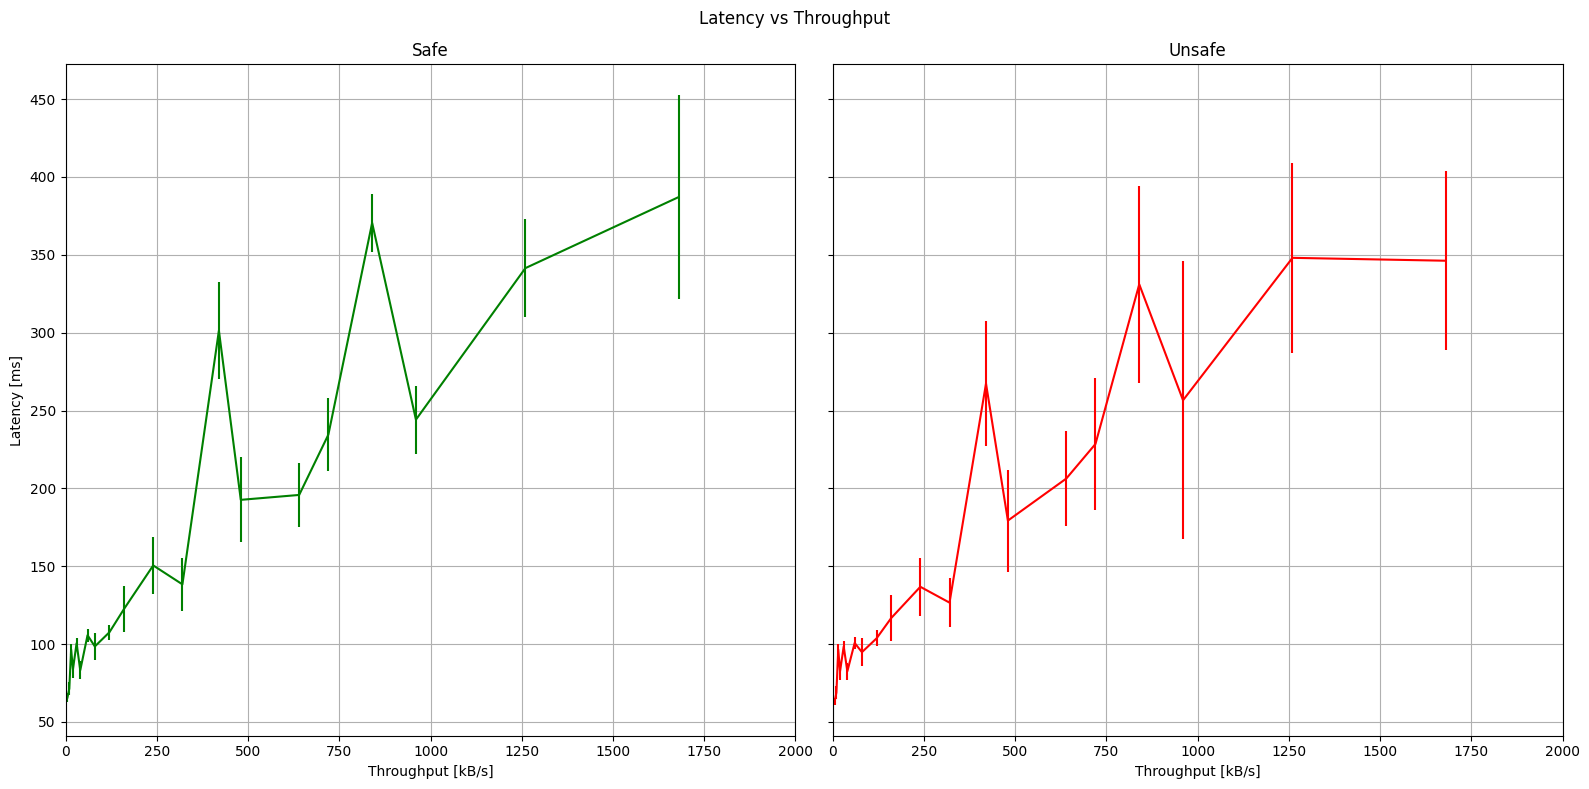

In [14]:
CRITERION = 'weak'
EVENT_TIME = None 
UUT = 'svea5'

# Collect the dataset
mask = DATA['sender'] != UUT
mask &= DATA['headway'] != 0
mask &= DATA['targ_vel'] <= 5
df = DATA[mask].copy()

# Apply analysis on each test
def analyze(df):
    
    latencies = df['arrival'] - df['sent'] # [ns] 
    latencies /= 1e6                       # [ms]
    
    return pd.DataFrame({
        'safe': safety(CRITERION, df, EVENT_TIME),
        'targ_vel': df['targ_vel'].iat[0],
        'throughput': (df['data_size'] * df['data_freq']).iat[0],
        'latency_avg': latencies.mean(),
        'latency_std': latencies.std(),
        'sample_size': len(df),
    }, index=[0])

df = (df.groupby('test')
        .apply(analyze)
        .droplevel(-1))

# Combine results over different tests
def combine(df):

    avg = df['latency_avg'].mean()
    
    std = df['latency_std']**2 / df['sample_size']
    std = np.sqrt(std.sum())
    
    return pd.DataFrame({
        'avg': pd.Series(avg),
        'std': pd.Series(std),
    })
    
df = (df.groupby(['targ_vel', 'safe', 'throughput'])
        .apply(combine)
        .droplevel(-1))

# Create figure & axes
fig, axs = plt.subplots(1, 2, 
                        sharey=True,
                        figsize=(16,8),
                        layout='tight')

# Draw plots
for (vel, safe), g in df.groupby(level=[0, 1]):
    g = g.droplevel([0, 1])
    
    g.plot(ax=axs[0 if safe else 1],
           grid=True,
           y='avg',
           yerr='std',
           c='g' if safe else 'r',
           label=f'Velocity: {vel} m/s')

fig.suptitle('Latency vs Throughput')
axs[0].set_title(f'Safe')
axs[1].set_title(f'Unsafe')
for ax in axs:
    ax.set_ylabel('Latency [ms]')
    ax.set_xlabel('Throughput [kB/s]')
    ax.set_xlim([0, 2000])
    ax.get_legend().remove()

None

### Latency vs Compute Time

**Background**: ???

**Expected Result**: Increasing latency or compute time should eventually lead to unsafe scenarios.

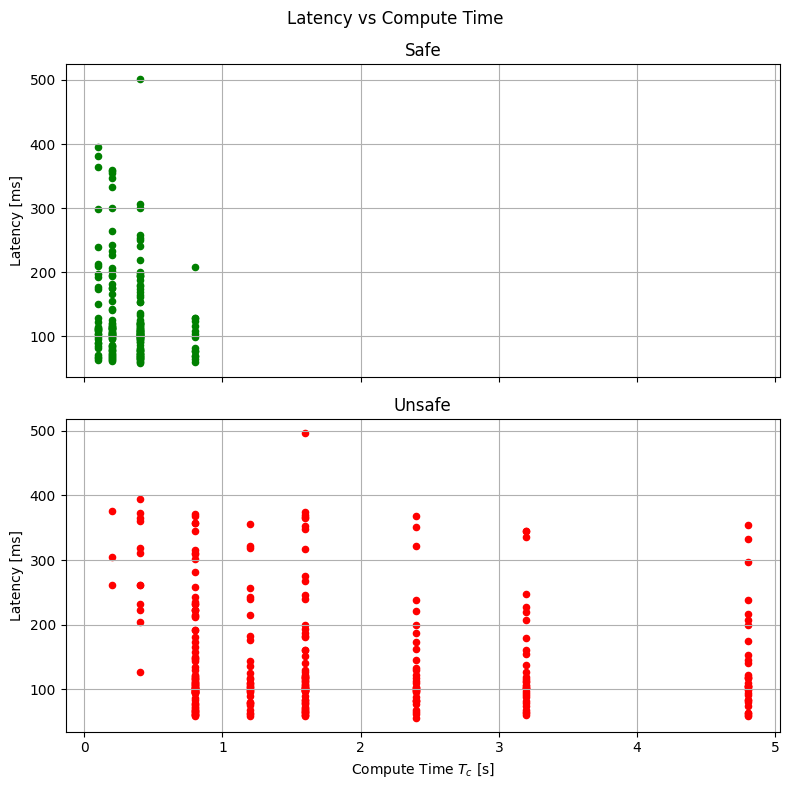

In [18]:
CRITERION = 'weak'
EVENT_TIME = None 
UUT = 'svea5'

# Collect the dataset
mask = DATA['sender'] != UUT
mask &= DATA['headway'] != 0
mask &= DATA['targ_vel'] <= 5
df = DATA[mask].copy()

# Apply analysis on each test
def analyze(df):
    
    latencies = df['arrival'] - df['sent'] # [ns] 
    latencies /= 1e6                       # [ms]
    
    return pd.DataFrame({
        'safe': safety(CRITERION, df, EVENT_TIME),
        'targ_vel': df['targ_vel'].iat[0],
        'latency_avg': latencies.mean(),
        'latency_std': latencies.std(),
        'compute_time': compute_time(df).iat[0],
    }, index=[0])

df = (df.groupby('test')
        .apply(analyze)
        .droplevel(-1))

# Create figure & axes
fig, axs = plt.subplots(2, 1,
                        figsize=(8, 8),
                        sharex=True,
                        layout='tight')

# Draw plots
for (vel, safe), g in df.groupby(['targ_vel', 'safe']):
    
    g.plot(ax=axs[0 if safe else 1],
           kind='scatter',
           grid=True,
           x='compute_time', 
           y='latency_avg',
           c='g' if safe else 'r',
           label=f'Velocity: {vel} m/s')

fig.suptitle('Latency vs Compute Time')
axs[0].set_title(f'Safe')
axs[1].set_title(f'Unsafe')
for ax in axs:
    ax.set_ylabel('Latency [ms]')
    ax.set_xlabel('Compute Time $T_c$ [s]')
    ax.get_legend().remove()

None

### Computational Complexity

**Background**:
It is probable that the apparent latency will increase when more vehicles are introduced (since $F$ would need to take in more messages that in turn might not arrive simultaneously). This prediction can be confirmed by looking at how many unsafe cases we have for different number of vehicles.

The same goes for increasing complexity of $F$, i.e. how it scales with $N$...

**Expected Result**: 
When increasing the number of vehicles or the complexity, number of unsafe cases should go up.

**Alternative Viewpoint**: 
When increasing the compute time (essentially what we are doing here) then the vehicle gets more time to receive incoming messages. This will allow the vehicle to collect more messages per scheduled execution of $F$ but they will also have higher apparent latency.

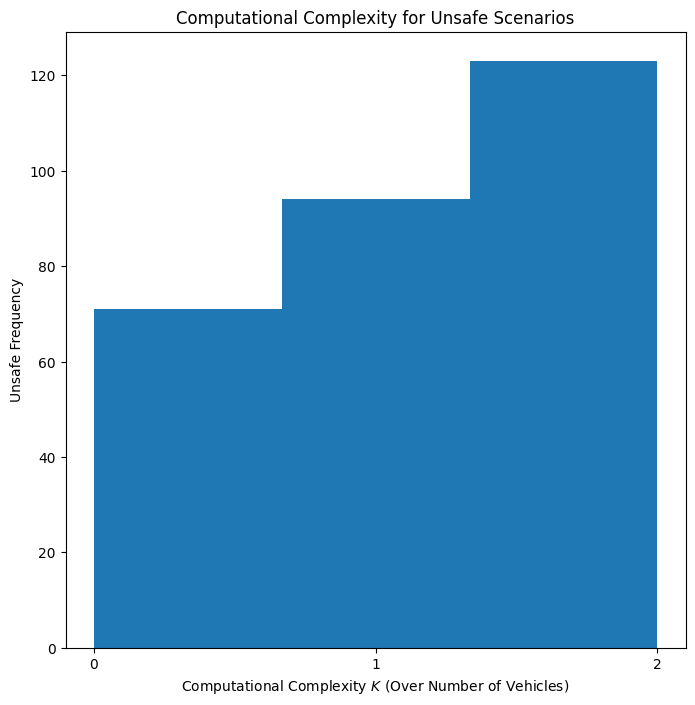

In [21]:
CRITERION = 'weak'
EVENT_TIME = None
UUT = 'svea5'

# Collect the dataset
mask = DATA['sender'] != UUT
mask &= DATA['headway'] != 0
mask &= DATA['targ_vel'] <= 5
df = DATA[mask].copy()

# Apply analysis on each test
def analyze(df):

    return pd.DataFrame({
        'safe': safety(CRITERION, df, EVENT_TIME),
        'complexity': df['comp_ordr'].iat[0],
    }, index=[0])

df = (df.groupby('test')
        .apply(analyze)
        .droplevel(-1))

# We are only interested in unsafe scenarios
mask = df['safe'] == False
df = df[mask]

# Create figure & axes
fig, ax = plt.figure(figsize=(8,8)), plt.gca()

# Draw plots
df['complexity'].plot(ax=ax,
                      kind='hist',
                      bins=3)

ax.set_title('Computational Complexity for Unsafe Scenarios')
ax.set_xlabel('Computational Complexity $K$ (Over Number of Vehicles)')
ax.set_ylabel(f'Unsafe Frequency')
ax.set_xticks([0, 1, 2])

None

### Scheduled time vs. Computed time
**Background**: The function $F$ does not necessarily compute at the same time as it is scheduled to execute (which we typically assume). Following is a check whether this is the case or not.

**Expected Result**: N/A

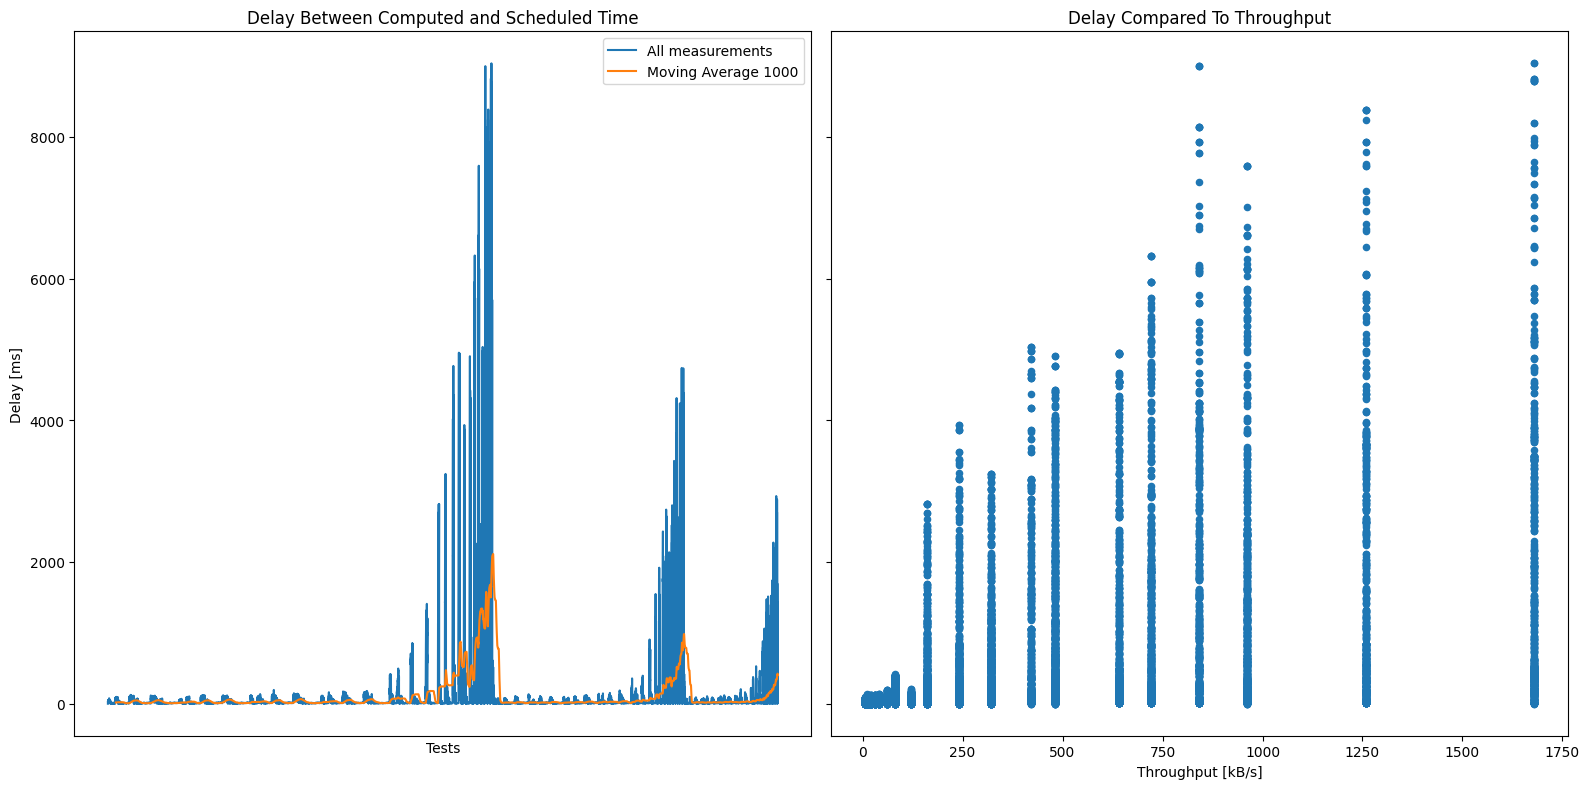

In [6]:
UUT = 'svea5'

# Collect the dataset
mask = DATA['sender'] != UUT
mask &= DATA['headway'] != 0
df = DATA[mask]

# Calculate computational delay
def analyze(df):
    
    comp_delay = df['last_computed'] - df['last_sched'] # [ns]
    comp_delay /= 1e6                                   # [ms]
    
    throughput = df['data_freq'] * df['data_size']
    
    return pd.DataFrame({
        'comp_delay': comp_delay,
        'throughput': throughput,
    })

df = (df.groupby('test', group_keys=True)
        .apply(analyze))

# Moving Average
MA_WIN = 1000
ma = df['comp_delay'].rolling(window=MA_WIN).mean()

# Create figure & axes
fig, axs = plt.subplots(1, 2, 
                        sharey=True,
                        figsize=(16,8),
                        layout='tight')

# Draw plots
df.plot(ax=axs[0], 
        y='comp_delay', 
        label='All measurements')
ma.plot(ax=axs[0], 
        label=f'Moving Average {MA_WIN}')

axs[0].set_title('Delay Between Computed and Scheduled Time')
axs[0].set_xlabel('Tests')
axs[0].set_ylabel('Delay [ms]')
axs[0].set_xticks([])
axs[0].legend()

df.plot(ax=axs[1], 
        kind='scatter',
        x='throughput',
        y='comp_delay')

axs[1].set_title('Delay Compared To Throughput')
axs[1].set_xlabel('Throughput [kB/s]')
axs[1].set_ylabel('Delay [ms]')

None

### How many scheduled executions per test?

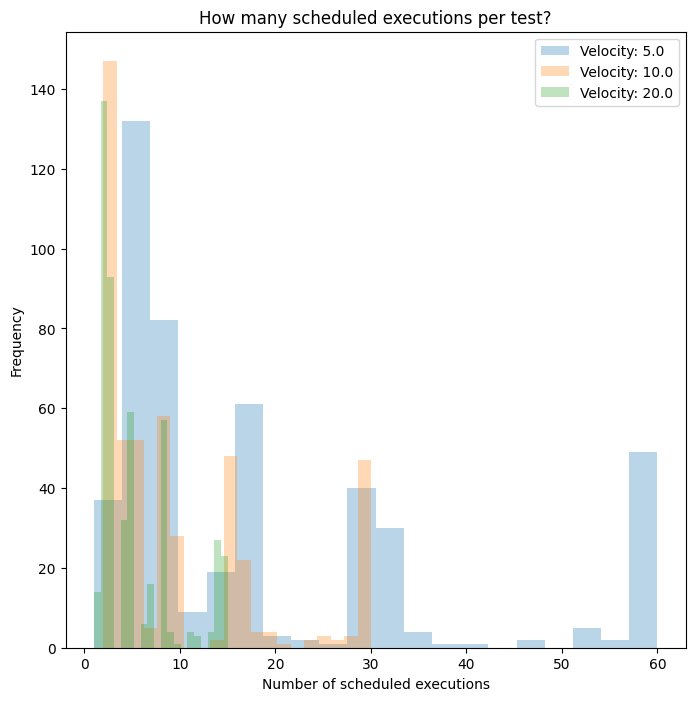

In [23]:
UUT = 'pi2'

# Collect the dataset
mask = DATA['sender'] != UUT
mask &= DATA['headway'] != 0
df = DATA[mask].copy()

# Apply analysis on each test
def analyze(df):
    
    return pd.DataFrame({
        'targ_vel': df['targ_vel'].iat[0],
        'sched_execs': len(df['last_sched'].unique()),
    }, index=[0])

df = (df.groupby('test')
        .apply(analyze)
        .droplevel(-1))

# Create figure & axes
fig, ax = plt.figure(figsize=(8, 8)), plt.gca()

# Draw plots
for vel, g in df.groupby('targ_vel'):
    
    xs = g['sched_execs']
    
    xs.plot(ax=ax,
            kind='hist',
            bins=20,
            alpha=0.3,
            label=f'Velocity: {vel}')

ax.set_title('How many scheduled executions per test?')
ax.set_xlabel('Number of scheduled executions')
ax.legend()
    
None

### Number of measurements for different velocities

Text(0.5, 0, 'Velocity [m/s]')

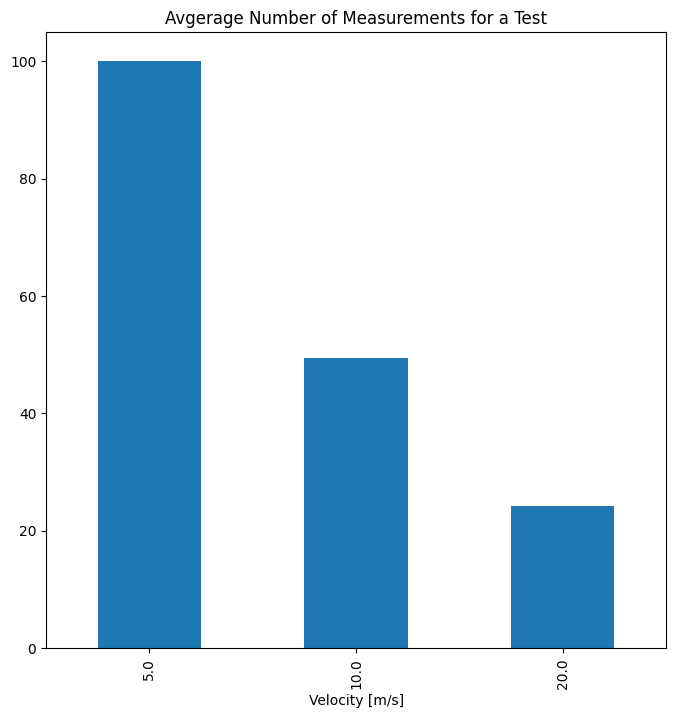

In [24]:
UUT = 'svea5'

# Collect the dataset
mask = DATA['sender'] != UUT
mask &= DATA['headway'] != 0
df = DATA[mask]

# Collect avereage size of tests for each velocity
def func(df):
    xs = df.groupby('test').size()
    return xs.mean()

xs = (df.groupby('targ_vel')
        .apply(func))

# Create figure & axes
fig, ax = plt.figure(figsize=(8, 8)), plt.gca()

# Draw plots
xs.plot(ax=ax,
        kind='bar')

ax.set_title('Avgerage Number of Measurements for a Test')
ax.set_xlabel('Velocity [m/s]')

## Old Plots

### How far does the vehicle go?

**Background**:
When the vehicle becomes unsafe, the vehicle will finish the test.
Thus, if we look at the headway at the last time step of each test
case then we can determine how near the intersection a vehicle can
go before becoming unsafe.

**Expected Result**:
That vehicles reach the intersection while being safe. 

/tmp/ipykernel_46008/2834049622.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['safe'] = False


NameError: name 'strong_safe' is not defined

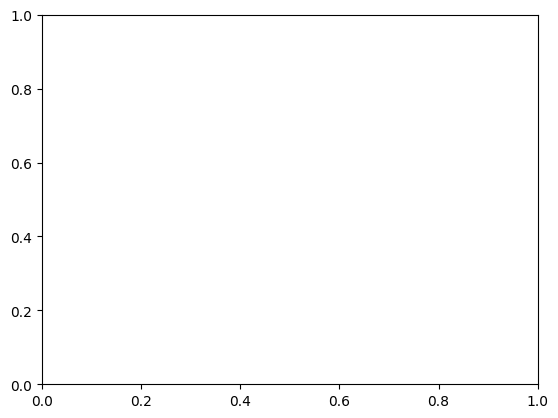

In [9]:
SAFETY_CRITERION = 'strong'
EVENT_TIME = None
UUT = 'svea5'


def analyze(df):

    # set safe according to SAFETY_CRITERION
    idx = (
        strong_safe(df, EVENT_TIME) if SAFETY_CRITERION == 'strong' else
        None
    )
    assert idx is not None, f'Invalid {SAFETY_CRITERION = }'
    df.loc[idx, 'safe'] = True
    
    # pick the first last-safe datapoint to represent this test
    df = df.groupby('safe').tail(1).head(1)
    
    return df[['comp_ordr', 'headway']]
    

# Create figure & axes
fig = plt.figure()
ax = fig.gca()

# Collect the dataset
mask = DATA['sender'] != UUT
df = DATA[mask]

# before TIME_EVENT we are always safe
df['safe'] = False

if EVENT_TIME is not None:
    mask = df['headway'] > EVENT_TIME
    df[mask]['safe'] = True
    
# Apply analysis
df = (df.groupby('test', group_keys=False)
        .apply(analyze))

# Draw plots
for i, g in df.groupby('comp_ordr'):
    
    g['headway'].plot(ax=ax,
                      kind='hist',
                      label=f'Complexity: {int(i)}',
                      alpha=0.3)

ax.set_title('How far does the vehicle go?')
ax.set_xlabel('Headway at final safe step [s]')
ax.legend()

None

### How far does the vehicle go?

**Background**:
Compare the actual compute time (i.e. including complexity) to the 
last headway time (i.e. a measure of distance to the intersection).

**Expected Result**:
Higher compute time should lead to higher number of unsafe scenarios.

In [ ]:
SAFETY_CRITERION = 'strong'
EVENT_TIME = None
UUT = 'svea5'


def analyze(df):

    # set safe according to SAFETY_CRITERION
    idx = (
        strong_safe(df, EVENT_TIME) if SAFETY_CRITERION == 'strong' else
        None
    )
    assert idx is not None, f'Invalid {SAFETY_CRITERION = }'
    df.loc[idx, 'safe'] = True
    
    df['compute_time'] = compute_time(df)
    
    return df

# Collect the dataset
mask = DATA['sender'] != UUT
df = DATA[mask].copy()

# before TIME_EVENT we are always safe
df['safe'] = False

if EVENT_TIME is not None:
    mask = df['headway'] > EVENT_TIME
    df.loc[mask, 'safe'] = True

# Apply analysis
df = (df.groupby('test', group_keys=False)
        .apply(analyze))

# Create figure & axes
fig = plt.figure()
ax = fig.gca()

# Draw plots
mask = df['safe']
df[mask].plot(ax=ax,
              kind='scatter',
              x='compute_time',
              y='headway',
              c='green')

mask = ~mask
df[mask].plot(ax=ax,
              kind='scatter',
              x='compute_time',
              y='headway',
              c='red')

ax.set_title('How far does the vehicle go?')
ax.set_xlabel('Actual Compute Time [s]')
ax.set_ylabel('Headway [s]')

None